In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook
import pickle
import os
import logging
import time
from IPython.core.debugger import set_trace
import glob

import torch
import torch.nn as nn
import torch.nn.functional as F

#from dataset_unet import prepare_trainset
from dataset_NIH import prepare_trainset
from utils import save_checkpoint, load_checkpoint, set_logger
from gpu_utils import set_n_get_device

#from model.model_unet import UNetResNet34, predict_proba
from model.model_unet_classify_zero import UNetResNet34, predict_proba
#from model.model_unet_classify_zero import UNetResNet34 as ZeroMaskClassifier

%matplotlib inline

In [5]:
######### Config the training process #########
#device = set_n_get_device("0, 1, 2, 3", data_device_id="cuda:0")#0, 1, 2, 3, IMPORTANT: data_device_id is set to free gpu for storing the model, e.g."cuda:1"
MODEL = 'UNetResNet34'#'RESNET34', 'RESNET18', 'INCEPTION_V3', 'BNINCEPTION', 'SEResnet50'
#AUX_LOGITS = True#False, only for 'INCEPTION_V3'
print('====MODEL ACHITECTURE: %s===='%MODEL)

device = set_n_get_device("1,3", data_device_id="cuda:0")#0, 1, 2, 3, IMPORTANT: data_device_id is set to free gpu for storing the model, e.g."cuda:1"
multi_gpu = [0, 1] #None

SEED = 1234#5678#4567#3456#2345#1234
debug = True# if True, load 100 samples
IMG_SIZE = 768#512
BATCH_SIZE = 16
NUM_WORKERS = 24
torch.cuda.manual_seed_all(SEED)

====MODEL ACHITECTURE: UNetResNet34====


## the dataset

In [6]:
train_dl, val_dl = prepare_trainset(BATCH_SIZE, NUM_WORKERS, SEED, IMG_SIZE, debug, use_sampler=True)

Count of trainset (for training):  900
Count of validset (for training):  100


In [13]:
for i, (images, labels) in enumerate(train_dl):
    images = images.to(device=device, dtype=torch.float)
    labels = labels.to(device=device, dtype=torch.float)
    #labels = (torch.sum(masks.reshape(masks.size()[0], -1), dim=1, keepdim=True)==0).to(device=device, dtype=torch.float) #1 for non-zero-mask
    if i==0:
        break

In [14]:
images.size(), labels.size(), labels.mean()

(torch.Size([16, 1, 768, 768]),
 torch.Size([16, 1]),
 tensor(0.3125, device='cuda:0'))

In [15]:
labels

tensor([[0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0')

## the model

In [6]:
net = UNetResNet34(debug=True).cuda(device=device)
#net = ZeroMaskClassifier(debug=True).cuda(device=device)

#torch.cuda.set_device(0)
#torch.distributed.init_process_group(backend='nccl', world_size=4, init_method='...')
#net = DistributedDataParallel(net, device_ids=[0], output_device=0)
#torch.distributed.init_process_group(backend="nccl")

#checkpoint_path = 'checkpoint/UNetResNet34_512_v1_seed3456/best.pth.tar'
#net, _ = load_checkpoint(checkpoint_path, net)

if multi_gpu is not None:
    net = nn.DataParallel(net, device_ids=multi_gpu)

In [7]:
logit = net(images)

input:  torch.Size([8, 3, 768, 768])
input:  torch.Size([8, 3, 768, 768])
e1 torch.Size([8, 64, 384, 384])
e1 torch.Size([8, 64, 384, 384])
e2 torch.Size([8, 64, 384, 384])
e2 torch.Size([8, 64, 384, 384])
e3 torch.Size([8, 128, 192, 192])
e3 torch.Size([8, 128, 192, 192])
e4 torch.Size([8, 256, 96, 96])
e4 torch.Size([8, 256, 96, 96])
e5 torch.Size([8, 512, 48, 48])
avgpool torch.Size([8, 512, 1, 1])
e5 torch.Size([8, 512, 48, 48])
avgpool torch.Size([8, 512, 1, 1])
reshape torch.Size([8, 512])
logit_clf torch.Size([8, 1])
reshape torch.Size([8, 512])
logit_clf torch.Size([8, 1])


/home/endi.niu/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [8]:
if multi_gpu:
    loss = net.module.criterion(logit, labels)

loss

tensor(0.7704, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)

In [9]:
if multi_gpu:
    metric, tn, fp, fn, tp = net.module.metric(logit, labels)

metric, tn, fp, fn, tp

(0.5, 0, 9, 0, 7)

In [11]:
%%time
#label_df = pd.read_csv('data/raw/NIH/NIH external data/label_df_pneumothorax.csv').set_index('img_id')

for idx, img_id in enumerate(label_df.index):
    if idx>10000:
        break
    has_pneumothorax = label_df.loc[img_id, 'has_pneumothorax']


CPU times: user 124 ms, sys: 0 ns, total: 124 ms
Wall time: 124 ms


In [27]:
for idx, f in enumerate(glob.glob('data/raw/NIH/NIH external data/images*/*')):
    img = plt.imread(f)
    if len(img.shape)==3:
        print(img.shape)
        break
    if idx>100:
        break
#img_path = glob.glob('data/raw/NIH/NIH external data/images*/00000001_000.png')[0]#00000003_000.png
#img = plt.imread(img_path)

(1024, 1024, 4)


In [28]:
img.shape

(1024, 1024, 4)

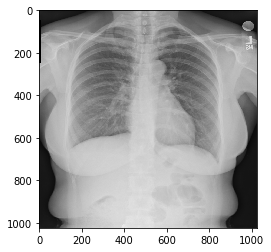

In [29]:
plt.imshow(img)

## predict the validset, and analyse  
**first, predict zero-nonzero-mask**

In [ ]:
#move checkpoint from gamma machine to here
cd checkpoint
scp -r endi.niu@10.171.36.214:/home/endi.niu/SIIM/checkpoint/nonzero_classifier_UNetResNet34_768_v1_seed1234/ nonzero_classifier_UNetResNet34_768_v1_seed1234
cd logging
scp -r endi.niu@10.171.36.214:/home/endi.niu/SIIM/logging/nonzero_classifier_UNetResNet34_768_v1_seed1234.log nonzero_classifier_UNetResNet34_768_v1_seed1234.log

In [1]:
import numpy as np
import pandas as pd
import math
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook
import pickle
import os
import logging
import time
from IPython.core.debugger import set_trace

import torch
import torch.nn as nn
import torch.nn.functional as F

from utils import save_checkpoint, load_checkpoint, set_logger
from gpu_utils import set_n_get_device

from model.model_unet_classify_zero import UNetResNet34, predict_proba
from dataset_NIH import prepare_trainset

from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report

%matplotlib inline

In [2]:
######### Config the training process #########
#device = set_n_get_device("0, 1, 2, 3", data_device_id="cuda:0")#0, 1, 2, 3, IMPORTANT: data_device_id is set to free gpu for storing the model, e.g."cuda:1"
MODEL = 'UNetResNet34'#'RESNET34', 'RESNET18', 'INCEPTION_V3', 'BNINCEPTION', 'SEResnet50'
#AUX_LOGITS = True#False, only for 'INCEPTION_V3'
print('====MODEL ACHITECTURE: %s===='%MODEL)

device = set_n_get_device("0", data_device_id="cuda:0")#0, 1, 2, 3, IMPORTANT: data_device_id is set to free gpu for storing the model, e.g."cuda:1"
multi_gpu = None#[0, 1]#use 2 gpus

SEED = 1234#5678#4567#3456#2345#1234
debug = False# if True, load 100 samples
IMG_SIZE = 768#512
BATCH_SIZE = 32
NUM_WORKERS = 24

====MODEL ACHITECTURE: UNetResNet34====


In [4]:
train_dl, val_dl = prepare_trainset(BATCH_SIZE, NUM_WORKERS, SEED, IMG_SIZE, debug)

In [4]:
# y should be makeup
y_valid = []
for i, (images, labels) in enumerate(val_dl):
    #if i==10:
    #    break
    #truth = masks.to(device=device, dtype=torch.float)
    #truth = (torch.sum(masks.reshape(masks.size()[0], -1), dim=1, keepdim=True)!=0).to(device=device, dtype=torch.float)
    y_valid.append(labels.cpu().numpy())
y_valid = np.concatenate(y_valid, axis=0)
y_valid.shape

(1120, 1)

In [5]:
y_valid.mean()

0.2839285714285714

In [6]:
net = UNetResNet34(debug=False).cuda(device=device)

In [7]:
checkpoint_path = 'checkpoint/nonzero_classifier_UNetResNet34_768_v1_seed1234/best.pth.tar'
net, _ = load_checkpoint(checkpoint_path, net)

In [8]:
%%time
# predict_proba
net.set_mode('valid')#.module
preds_valid = predict_proba(net, val_dl, device, multi_gpu=False, mode='valid', tta=True)

/home/endi.niu/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


CPU times: user 3min 25s, sys: 11.8 s, total: 3min 37s
Wall time: 48.4 s


In [9]:
y_valid.shape, preds_valid.shape

((1120, 1), (1120, 1))

In [10]:
from sklearn.metrics import roc_auc_score, confusion_matrix

In [16]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def cal_metric(logit, truth):
    #pred = sigmoid(logit.cpu().detach())
    pred = sigmoid(logit)
    #truth = truth.cpu().detach()
    ##
    THRESHOLD_candidate = np.arange(0.01, 0.99, 0.01)#np.arange(0.1, 1.0, 0.1)
    N = len(THRESHOLD_candidate)
    best_threshold = None
    best_score = 9999
    tn, fp, fn, tp, auc, pos_percent = 0, 0, 0, 0, 0.0, 0.0
    for i in range(N):
        THRESHOLD = THRESHOLD_candidate[i]
        _pred = pred>THRESHOLD
        _tn, _fp, _fn, _tp = confusion_matrix(truth, _pred).ravel()
        _auc = round(roc_auc_score(truth, _pred), 5)
        if _tn+_fn==0:
            fn_rate = 9999
        else:
            fn_rate = round(_fn/(_tn+_fn), 5)
        #predict positive proportion should be ~28%
        _pos_percent = (_tp+_fp)/(_tp+_fp+_tn+_fn)
        if 0.25<_pos_percent<0.28:
            if fn_rate < best_score:
                best_threshold = THRESHOLD
                best_score = fn_rate
                tn, fp, fn, tp, auc, pos_percent = _tn, _fp, _fn, _tp, _auc, _pos_percent
    return best_score, tn, fp, fn, tp, auc, pos_percent, best_threshold

In [17]:
best_score, tn, fp, fn, tp, auc, pos_percent, best_threshold = cal_metric(preds_valid, y_valid)
best_score, tn, fp, fn, tp, auc, pos_percent, best_threshold

(0.0223, 789, 13, 18, 300, 0.96359, 0.2794642857142857, 0.51)

In [14]:
# THRESHOLD_candidate = np.arange(0.01, 0.99, 0.01)#np.arange(0.1, 1.0, 0.1)

# N = len(THRESHOLD_candidate)
# best_threshold = None
# best_score = 9999

# for i in tqdm_notebook(range(N)):
#     THRESHOLD = THRESHOLD_candidate[i]
#     auc, fn_rate, tn, fp, fn, tp = cal_metric(preds_valid, y_valid, THRESHOLD)
#     #predict positive proportion should be ~28%
#     pos_percent = (tp+fp)/(tp+fp+tn+fn)
#     if 0.2<pos_percent<0.28:
#         flag = 'Yes'
#         if fn_rate < best_score:
#             best_threshold = THRESHOLD
#             best_score = fn_rate
#     else:
#         flag = 'No'
#     print('[%s]THRESHOLD: %.2f, metric_score: %.5f, pos_percent: %.3f; tn, fp, fn, tp, auc: %d, %d, %d, %d, %.5f'%(flag, THRESHOLD, fn_rate, pos_percent, tn, fp, fn, tp, auc))


In [15]:
# THRESHOLD = best_threshold
# THRESHOLD, best_score

In [18]:
print(classification_report(y_valid, sigmoid(preds_valid)>best_threshold))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       802
           1       0.96      0.94      0.95       318

    accuracy                           0.97      1120
   macro avg       0.97      0.96      0.97      1120
weighted avg       0.97      0.97      0.97      1120



In [20]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def predict_mask(logit, best_threshold):
    """Transform each prediction into mask.
    input shape: (256, 256)
    """
    #pred mask 0-1 pixel-wise
    #n = logit.shape[0]
    #IMG_SIZE = logit.shape[-1] #256
    #EMPTY_THRESHOLD = 100.0*(IMG_SIZE/128.0)**2 #count of predicted mask pixles<threshold, predict as empty mask image
    #MASK_THRESHOLD = 0.22
    #logit = torch.sigmoid(torch.from_numpy(logit)).view(n, -1)
    #pred = (logit>MASK_THRESHOLD).long()
    #pred[pred.sum(dim=1) < EMPTY_THRESHOLD, ] = 0 #bug here, found it, the bug is input shape is (256, 256) not (16,256,256)
    logit = sigmoid(logit)#.reshape(n, -1)
    pred = (logit>best_threshold).astype(np.int)
    return pred

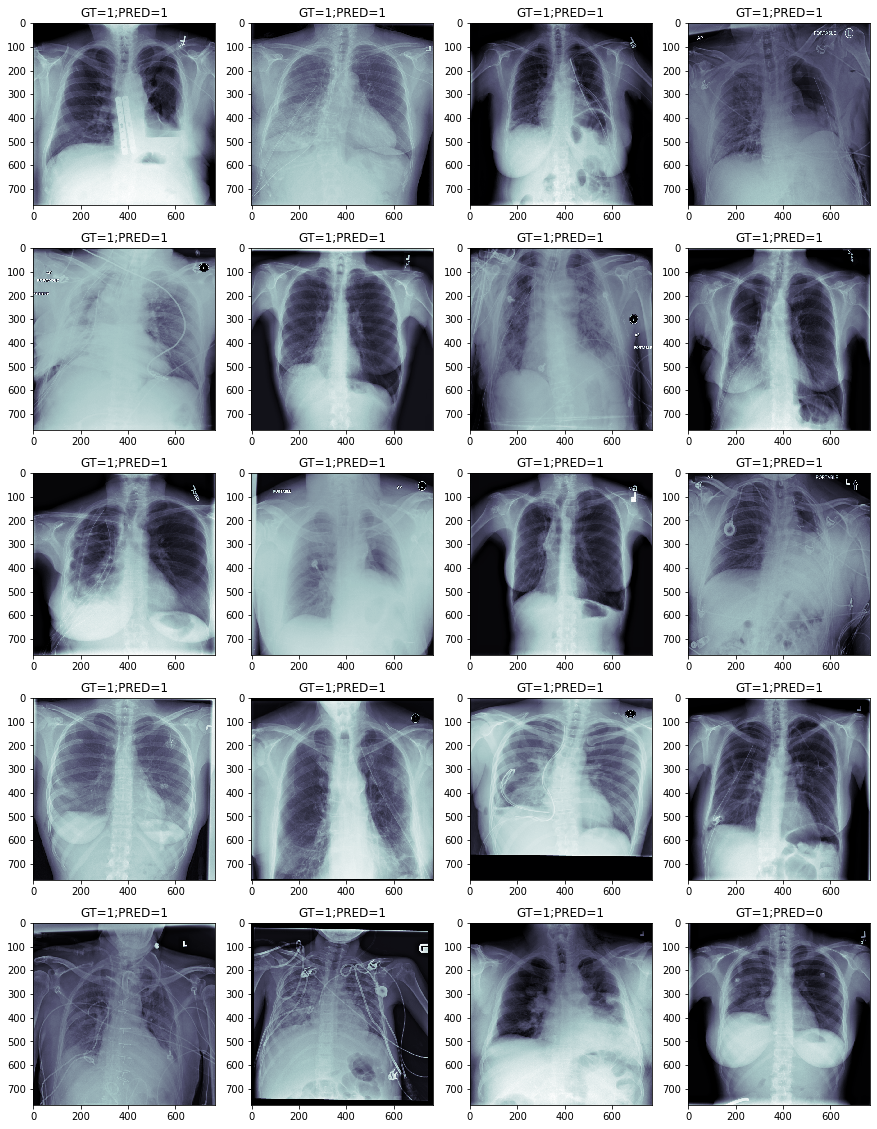

In [22]:
## visualize predicted masks
start = 0
total = 19

fig=plt.figure(figsize=(15, 20))
cnt = 0
for idx, (images, labels) in enumerate(val_dl):
    if idx<start:
        continue
    for j in range(BATCH_SIZE):#BATCH_SIZE=8
        cnt+=1
        pred_mask = predict_mask(preds_valid[idx*BATCH_SIZE+j], best_threshold)
        #if pred_mask.float().mean()==0:
        #    continue
        ax = fig.add_subplot(5, 4, cnt)
        plt.imshow(images[j][0].numpy(), plt.cm.bone)
        if labels[j]==1:
            title = 'GT=1'
        else:
            title = 'GT=0'
        if pred_mask==1:
            title += ';PRED=1'
        else:
            title += ';PRED=0'
        plt.title(title)
        if cnt>total:
            break
    if cnt>total:
            break

In [ ]:
#100, 256, 334, 378, 547, 667, 916
#47, 173
plt.imshow(_logit[173], cmap='Reds')
#plt.imshow(_logit[256]>0.001, cmap='Reds')
#(_logit[100]>0.01).sum()

In [ ]:
#_logit = sigmoid(preds_valid_masks)#.reshape(n, -1)
_pred = (_logit>MASK_THRESHOLD).astype(np.int)
_pred_clf = (_pred.reshape(_pred.shape[0], -1).sum(axis=1)<EMPTY_THRESHOLD).astype(np.int)
#pred[pred_clf.reshape(-1,)==1, ] = 0

In [ ]:
#unet mask model
print(classification_report(y_valid[:, 0], 1-_pred_clf[:y_valid.shape[0]]))

In [ ]:
(1-_pred_clf[:y_valid.shape[0]]).mean()

In [ ]:
#classify zero-nonzero model
print(classification_report(y_valid, sigmoid(preds_valid)>THRESHOLD))

In [ ]:
(sigmoid(preds_valid)>THRESHOLD).mean()